Coen is a high school student doing a project on the brain, he is interested in finding the most connected area in the (rodent) brain. He fires up the CCP and sorts areas according the number or the weighted combination of strength and number of connections. He then selects the top area and makes a number of 2D slices and 3D visualizations of the projection of this area for inclusion in this project report.

Initially a series of data structures, files and functions that have to be utilized throughout the analysis have to be stored in the current directory space. 

In [1]:
import os
import pickle as pk
from IPython.display import clear_output
client      = get_bbp_client().document
#collab_path = get_collab_storage_path()
collab_path = '8650'
ccp_path    = 'CCP v2'
itemlist = client.listdir(os.path.join(collab_path,ccp_path))
for element in itemlist:
    if os.path.isfile('./' + str(element)) == True: continue
    if 'Library.py' in element: continue
    print 'element {} has been downloaded'.format(element)
    local_path = './' + element
    client.download_file(os.path.join(collab_path,ccp_path, element),local_path)
    clear_output()

The cfg.py file is used for updating and importing all useful libraries to be used throughout the analysis.
Moreover, all functions/classes inside cfg.py (find_notebook, NotebookLoader, NotebookFinder) were taken from a tutorial on how to import external jupyter notebooks as modules.  
Documentations about the aforementioned functions and classes can be found in this link:  
https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html  
The code below is responsible for downloading the aforementioned data from the storage space.  

In [2]:
from cfg import *

In this step a series of libraries whose classes and functions have to be utilized throughout the analysis,  
are being downloaded from the storage space and imported as modules.

In [3]:
elements = ['PrimaryLibrary.ipynb','Allen_API_Library.ipynb']
for element in elements:
    local_path = './' + element
    client.download_file(os.path.join(collab_path, element),local_path)

import PrimaryLibrary as PL
imp.reload(PL)

clear_output()

In this cell, an initialization of an sbaInterface_class instance is being made.
The sbaInterface_class serves as an API for calling the Scalable Brain Composer (SBA)  brain visualization tool. As shown by the steps below, we will use the SBA for a series of visualizations.  
As soon as the initialization is being made, a window will pop-up. On later steps, values will be passed to SBA which will lead to visualizations displayed in the aforementioned window.

In [4]:
# SBA Composer page to load: here it is the -dev version and atlas ABA_v3
sbaHost = 'https://scalablebrainatlas.incf.org/composer-dev';
sbaUrl  = sbaHost+'/?template=ABA_v3';

sbaInterface = PL.sbaInterface_class(sbaUrl,sbaHost)

### Step 1: Load unionized data / parameter Initialization  
Coen is able to access data from the Allen Institute for Brain Science regarding connectivity patterns between anatomically distinct brain areas. The script shows how such data can be accessed from the HBP collaboratory.

Before the analysis initiation, an instance of class MesoconnectomePredictor is being created (MesoPred) in order to load and manipulate the connectivity pattern data.

In [5]:
MesoPred = PL.MesoconnectomePredictor()

Once the MesoPred instance has been initialized, we select connectivity patterns by selecting the ConDict element of our instance. The ConDict is a dictionary that stores connectivity patterns over sets of different tract tracing experiments.  
Let's assume that Coen is interested in wild-type experiments, meaning experiments regarding non transgenic mice whose connectivity patterns are measured by connectivity strength between brain areas.    
The following command shows how to acquire such data.

In [6]:
ConStr       = MesoPred.ConDict['wild_type']['ConMat']
source_areas = MesoPred.ConDict['wild_type']['structure-abbrev']
print np.shape(ConStr)

(1327, 498)


The shape printed above indicates the number of target and source brain areas respectively.  
The ConMat keyword is used to store the Connectivity Matrix associated with the aforementioned experiments.   
The structure-abbrev stands for structure abbreviation and contains information about the acronyms of the source brain areas.

Afterwards, for removing redundant information we reduce our gene expression data to a set of structural brain areas that have the finest possible level of description (leaf keys).  

In [7]:
ConStr_reduced  = np.asarray(ConStr)[MesoPred.params['leaf_keys'],:]
print np.shape(ConStr_reduced)

(1038, 498)


We observe that the structures have been reduced from 1327 to 1038. Let's proceed more with pre-processing.  

The pre-processing function cleans the dataset from NaN (not a number) values and outliers, performs cubic root transformation to achieve a less skewed distribution, and z-scores the data for faster algorithmic convergence.  

In [8]:
ConStr_new, scaler  = MesoPred.PreProcessing(ConStr = ConStr_reduced, params = MesoPred.params)
clear_output()

Since we are not interested in training a predictive model but instead testing the data on pre-existing ones, the data are being re-scaled with a scaler object back to their pre-scaled form.

In [9]:
ConStr_res  = scaler.inverse_transform(ConStr_new)
print 'The shape of the connectivity array is: {}'.format(np.shape(ConStr_res))

The shape of the connectivity array is: (585, 498)


### Step 2: Select area of interest   
 The target_areas is a list of names associated with the target brain areas which we can access from MesoPred as shown below.

In [10]:
target_areas = MesoPred.params['str_cpy']

Since Coen is interested in the highest projected area, we estimate for all target areas the sum of their projections as a measure of their overall projected strength. Afterwards and we select the highest one.   

In [11]:
overall_strength  = np.sum(ConStr_res, axis = 1)
top_target_id     = np.argmax(overall_strength)
top_target_name   = target_areas[top_target_id]
print 'The highest projected area is: {}\nwith overall projection strength: {}'.format(top_target_name, overall_strength[top_target_id])

The highest projected area is: CP
with overall projection strength: 356.809741422


### Step 3: Select projections based on strength  
Given that Caudoputamen is the highest projected area, the next step is the selection of indicative source areas for visualization.    
We shall select the one most highly projecting to CP and use its associated projection patterns as data input for our visualization routines.

In [12]:
sorted_sources        = np.argsort(ConStr_res[top_target_id,:])[::-1]
selected_source_id    = sorted_sources[0]
selected_source_name  = MesoPred.params['structure-abbrev'][selected_source_id]
print 'The selected source area is: {}'.format(selected_source_name)

The selected source area is: MOs


### Step 4: Brain Visualization   
In this step, the projection patterns of MOs across the mouse brain are being visually inspected with three different approaches:
*  Brain slice visualization with the use of the BrainPlotter tool.
*  3D brain visualization with the use of the Scalable Brain Composer (SBA) tool.
*  Cortical flatmap visualization the use of the BrainPlotter tool.

#### Brain Slice visualization

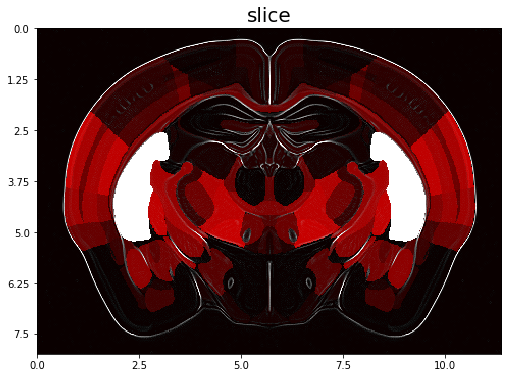

In [13]:
BP_25 = PL.BrainPlotter(resolution = 25)
BP_25.fit(projection = ConStr_res[:,selected_source_id], 
          chosen_indices = MesoPred.params['remaining_indices'])
BP_25.plot_slice()

#### Call to the SBA tool   
When SBA is being called, a green pop-up window will show up. If the user clicks on "Re-open SBA Composer" the results will be displayed on the window that was opened during the first steps.   
The user can navigate through the various parts of the mouse brain for visual inspection, by utilizing the buttons on the right part of the screen.  
A tutorial for the tool is being provided by clicking at the Readme & FAQ button at the left top of the screen. 

In [14]:
sbaCommand = BP_25.Call_SBA(InputData = BP_25.pd, mode = 'nifti')
sbaInterface.send(sbaCommand)
clear_output()

#### Cortical flatmap visualization

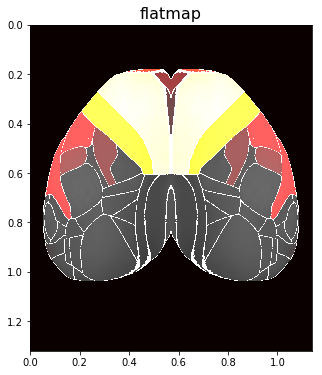

In [15]:
BP_10 = PL.BrainPlotter(resolution = 10)
BP_10.fit(projection = ConStr_res[:,selected_source_id], 
          chosen_indices = MesoPred.params['remaining_indices'])
BP_10.plot_flatmap()